In [1]:
%cd ../../

/mnt/sda/otani/Experiments/eval-detection


In [2]:
from jupyter_bbox_widget import BBoxWidget
import numpy as np
import ot
from src.extensions.metrics.ot_cost import get_ot_cost, get_cmap, bbox_gious
import ipywidgets as widgets
import matplotlib.pyplot as plt
from src.extensions.metrics.ot_cost import add_label, get_bbox_overlaps
from matplotlib.patches import Rectangle
from matplotlib.pyplot import cm
%matplotlib inline

In [3]:
def display_alignment(cmap_fnc):
    gt_bboxes = [b for b in bbox_widget.bboxes if b["label"].startswith("GT")]
    fmt_gt_bboxes, gt_bbox_indices = format_bboxes(gt_bboxes, CLASS_LABELS, return_orders=True)
    bboxes = [b for b in bbox_widget.bboxes if not b["label"].startswith("GT")]
    fmt_bboxes, bbox_indices = format_bboxes(bboxes, CLASS_LABELS, return_orders=True)
    otc, log = get_ot_cost(fmt_gt_bboxes, fmt_bboxes, cmap_fnc, return_matrix=True)

    img = plt.imread("data/sample_img/fruits.jpeg")
    plt.imshow(img)
    ax = plt.gca()

    # draw gt bboxes
    color = cm.rainbow(np.linspace(0, 1, len(gt_bboxes)+1))
    for bi, c in zip(gt_bbox_indices, color):
        b = gt_bboxes[bi]
        rect = Rectangle((b["x"], b["y"]), b["width"], b["height"], lw=2, ec=c, fc="None")
        ax.add_patch(rect)   

    # draw bboxes
    for weight, c in zip(log["G"], color):
        for bi, w in zip(bbox_indices, weight):
            b = bboxes[bi]
            rect = Rectangle((b["x"], b["y"]), b["width"], b["height"], lw=2, ec=c, fc=c, alpha=w)
            ax.add_patch(rect)   

    plt.show()

In [4]:
# from src.extensions.metrics.ot_cost import add_label, get_bbox_overlaps

# def get_distmap_bg(a_result, b_result, mode="giou"):
#     """[summary]

#     Args:
#         a_result ([type]): ground truth bounding boxes.
#         b_result ([type]): predictions
#         mode (str, optional): [description]. Defaults to "giou".

#     Returns:
#         dist_a (np.array): (N+1,) array. distribution over ground truth bounding boxes.
#         dist_b (np.array): (M,) array. distribution over predictions.
#         cost_map: 
#     """
#     a_result = add_label(a_result)
#     b_result = add_label(b_result)
#     n = len(a_result)
#     m = len(b_result)
#     r = m - n

#     cost_map = np.zeros((n+1, m))

#     dist_iou = get_bbox_overlaps(a_result[:, :4], b_result[:, :4], mode=mode)

#     if mode == "giou":  # giou range [-1, 1] -> [0, 1]
#         dist_iou += 1
#         dist_iou *= 0.5

#     dist_iou = (1 - dist_iou) * .5
#     cost_map[:n, :m] = dist_iou
#     cost_map[-1, :] = 0.5

#     dist_cls = np.zeros((n+1, m))

#     for i in range(n):
#         for j in range(m):
#             if a_result[i, -1] == b_result[j, -1]:
#                 dist_cls[i, j] = a_result[i, -2] - b_result[j, -2]
#             else:
#                 dist_cls[i, j] = a_result[i, -2] + b_result[j, -2]
#     dist_cls[-1, :] = [1 + b[-2] for b in b_result]

#     dist_cls = np.abs(dist_cls * 0.5)
#     cost_map += dist_cls * 0.5

#     dist_a = np.ones(n+1)
#     dist_a[-1] = max(r, 0)
#     dist_a /= dist_a.sum()

#     dist_b = np.ones(m) / m

#     return dist_a, dist_b, cost_map

In [47]:
# def cost_func(x, y):
#     loc_cost = (1 - bbox_gious(x[:4][None, :], y[:4][None, :])) * 0.5 # normalized to [0, 1]
#     l_x, l_y = x[-1], y[-1]
#     if l_x == l_y:
#         cls_cost = np.abs(x[-2] - y[-2])
#     else:
#         cls_cost = x[-2] + y[-2]
#     cls_cost *= 0.5 # normalized to [0, 1]
#     alpha = 0.8
#     return alpha * loc_cost + (1-alpha) * cls_cost

    
# def generate_cmap(a_result, b_result):
#     a_result = add_label(a_result)
#     b_result = add_label(b_result)
#     n = len(a_result)
#     m = len(b_result)

#     cost_map = np.zeros((n + 1, m + 1))
#     cost_map[:n, :m] = ot.utils.dist(a_result, b_result, cost_func)

#     # cost for dummy demander / supplier
#     cost_map[-1, :] = 1.
#     cost_map[:, -1] = 1.

#     dist_a = np.ones(n + 1)
#     dist_a[-1] = max(m-n, 0)
#     dist_a /= dist_a.sum()

#     dist_b = np.ones(m + 1)
#     dist_b[-1] = max(n-m, 0)
#     dist_b /= dist_b.sum()

#     return dist_a, dist_b, cost_map

In [4]:
from IPython.display import display

CLASS_LABELS = ["apple", "lemon", "banana"]
n_class = len(CLASS_LABELS)
img_file = 'data/sample_img/fruits.jpeg'


bbox_widget = BBoxWidget(
    image="../../"+img_file,
    classes= CLASS_LABELS + [" ".join(["GT", l]) for l in CLASS_LABELS],
    colors=["green"] * n_class + ["orange"] * n_class,
    hide_buttons=True
    )

w_conf = widgets.FloatSlider(value=0.5, min=0, max=1., description='Confidence')
bbox_widget.attach(w_conf, name="confidence")

def format_bboxes(bboxes, classes, return_orders=False):
    orders = []
    formatted_bboxes = []
    for label in classes:
        formatted_bboxes.append([])
        for i, bbox in enumerate(bboxes):
            if label in bbox["label"]:
                if bbox["label"].startswith("GT"):
                    conf = 1 
                else:
                    conf = bbox["confidence"]
                formatted_bboxes[-1].append([bbox["x"], bbox["y"], bbox["x"]+bbox["width"], bbox["y"]+bbox["height"], conf])
                orders.append(i)
        formatted_bboxes[-1] = np.asarray(formatted_bboxes[-1], dtype=np.float32).reshape(-1, 5)
    if return_orders:
        return formatted_bboxes, orders
    return formatted_bboxes
    
def evaluate_bboxes():
    gt_bboxes = [b for b in bbox_widget.bboxes if b["label"].startswith("GT")]
    gt_bboxes = format_bboxes(gt_bboxes, CLASS_LABELS)
    bboxes = [b for b in bbox_widget.bboxes if not b["label"].startswith("GT")]
    bboxes = format_bboxes(bboxes, CLASS_LABELS)
    cmap_func = lambda x, y: get_cmap(x, y, use_dummy=True)
    otc, log = get_ot_cost(gt_bboxes, bboxes, get_cmap, return_matrix=True)
    return otc, log

w_out = widgets.Output()

def get_label_count(c_name):
    return len([b for b in bbox_widget.bboxes if b["label"].split()[0] == c_name])

def update_label_conf():
    idx = bbox_widget.selected_index
    cur_label = bbox_widget.bboxes[idx]["label"]

    if cur_label.startswith("GT"):
        return
    
    for c_name in CLASS_LABELS:
        if c_name in cur_label:
            break

    # re-label bboxes of c_name class
    count = 0
    for idx, b in enumerate(bbox_widget.bboxes):
        if b["label"].startswith("GT"):
            continue
        if c_name in b["label"]:
            count += 1
            conf = b["confidence"]
            new_label = f"{c_name}[{count}] ({conf})"
            bbox_widget._set_bbox_property(idx, "label", new_label)

def on_bbox_change(change):
    update_label_conf()

    w_out.clear_output(wait=True)
    otc, log = evaluate_bboxes()
    with w_out:
        print(f"{otc:.3f}")
        print(log['G'])
        
bbox_widget.observe(on_bbox_change, names=['bboxes'])

w_container = widgets.VBox([
    bbox_widget,
    w_conf,
    w_out,
])
display(w_container)

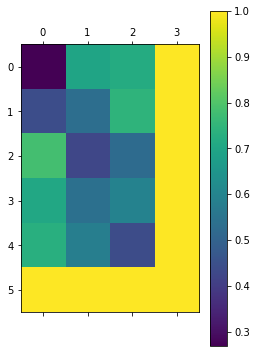

In [60]:
# def get_cmap():
#     gt_bboxes = [b for b in bbox_widget.bboxes if b["label"].startswith("GT")]
#     gt_bboxes = format_bboxes(gt_bboxes, CLASS_LABELS)
#     bboxes = [b for b in bbox_widget.bboxes if not b["label"].startswith("GT")]
#     bboxes = format_bboxes(bboxes, CLASS_LABELS)
#     _, _, M = generate_cmap(bboxes, gt_bboxes)
#     return M
# plt.matshow(get_cmap())
# plt.colorbar()

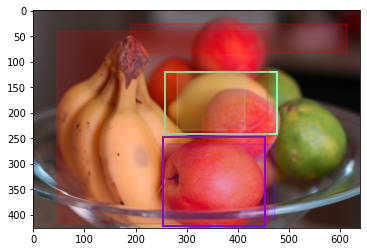

In [7]:
cmap_fnc = lambda x, y: get_cmap(x, y, use_dummy=True)
display_alignment(cmap_fnc)

In [36]:
def get_bboxes():
    gt_bboxes = [b for b in bbox_widget.bboxes if b["label"].startswith("GT")]
    gt_bboxes = format_bboxes(gt_bboxes, CLASS_LABELS)
    bboxes = [b for b in bbox_widget.bboxes if not b["label"].startswith("GT")]
    bboxes = format_bboxes(bboxes, CLASS_LABELS)
    return gt_bboxes, bboxes

gt_bboxes, bboxes = get_bboxes()
get_bbox_overlaps(np.vstack(gt_bboxes)[:,:4], np.vstack(bboxes)[:,:4])

array([[0.61418813, 0.536864  ],
       [0.5547059 , 0.15544042]], dtype=float32)

In [30]:
import ot

def get_bboxes():
    gt_bboxes = [b for b in bbox_widget.bboxes if b["label"].startswith("GT")]
    gt_bboxes = format_bboxes(gt_bboxes, CLASS_LABELS)
    bboxes = [b for b in bbox_widget.bboxes if not b["label"].startswith("GT")]
    bboxes = format_bboxes(bboxes, CLASS_LABELS)
    return gt_bboxes, bboxes

gt_bboxes, bboxes = get_bboxes()
a, b, M = get_distmap_bg(gt_bboxes, bboxes)
# ot.emd2(a, b, M, return_matrix=True)

In [9]:
bboxes

[array([[319. , 281. , 495. , 406. ,   0.5]], dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32)]

[0.33333333 0.         0.        ]
[0.         0.33333333 0.        ]
[0.         0.         0.33333333]
[0. 0. 0.]


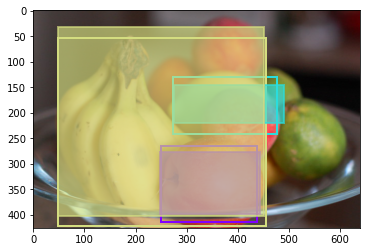